In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import config
import network

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [3]:
mask_100206_long_pro = process_data.get_mask_pro(scan_100206, mask_100206)

In [4]:
normalized_scan_100206_full = np.load(config.norm_data_path + '/normalized_scan_100206_full.npy')

In [5]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [76]:
rand_sub_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 5))

In [77]:
rand_sub_bval_indice_100206

array([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 256, 257, 258,
       259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271,
       272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284,
       285, 286, 287])

In [78]:
bvals_100206_sub = bvals_all_100206[rand_sub_bval_indice_100206]*1e-3

In [79]:
normalized_scan_100206_sub = normalized_scan_100206_full[:, rand_sub_bval_indice_100206]

In [80]:
big_b_indice_100206_sub = np.where(bvals_100206_sub != 0.005)[0]

In [81]:
bvals_100206_sub_no_b5 = bvals_100206_sub[big_b_indice_100206_sub]

In [82]:
normalized_scan_100206_sub_no_b5 = normalized_scan_100206_sub[:, big_b_indice_100206_sub]

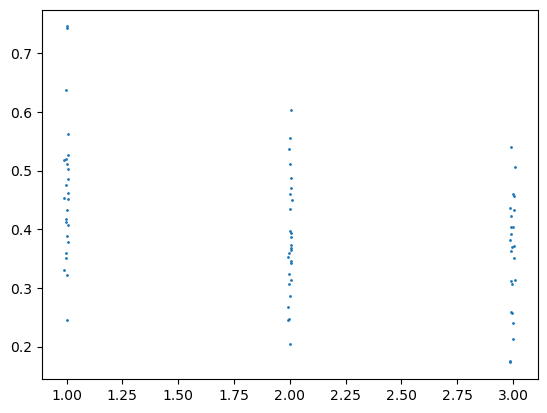

In [83]:
plt.plot(bvals_100206_sub_no_b5, normalized_scan_100206_sub_no_b5[42,:], "o", markersize = 1)

ANN

In [49]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [50]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [51]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, theta, phi, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [84]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')

In [85]:
n_100206_sub = n_100206_all[:, rand_sub_bval_indice_100206]
n_100206_sub_no_b5 = n_100206_sub[:,big_b_indice_100206_sub].T
print(n_100206_sub_no_b5.shape)

b_values_100206_sub_no_b5 = torch.FloatTensor(bvals_100206_sub_no_b5)
gradient_directions_100206_sub_no_b5 = torch.FloatTensor(n_100206_sub_no_b5)

(76, 3)


In [86]:
net = network.BallStickNet(gradient_directions_100206_sub_no_b5, b_values_100206_sub_no_b5)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

In [87]:
batch_size = 128
num_batches = len(normalized_scan_100206_sub_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_sub_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [88]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.69it/s]


Loss: 2599.507413238287
Average Loss: 0.3557070899340842
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 311.76it/s]


Loss: 2596.094876766205
Average Loss: 0.35524013092038925
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.53it/s]


Loss: 2594.193345248699
Average Loss: 0.35497993230004093
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 294.11it/s]


Loss: 2593.478780180216
Average Loss: 0.3548821538287104
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 295.61it/s]


Loss: 2593.1955038309097
Average Loss: 0.3548433913288054
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 295.47it/s]


Loss: 2592.737773567438
Average Loss: 0.354780757193136
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 302.05it/s]


Loss: 2592.5585764944553
Average Loss: 0.3547562365208614
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 297.45it/s]


Loss: 2144.553688623011
Average Loss: 0.2934528856900672
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.00it/s]


Loss: 1231.5964898467064
Average Loss: 0.1685271606248914
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.11it/s]


Loss: 1216.5148151218891
Average Loss: 0.1664634393981786
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  2%|███                                                                                                                                                           | 144/7308 [00:02<00:52, 136.82it/s]

X_batch: 
torch.Size([128, 76])
tensor([[0.5773, 0.3967, 0.2528,  ..., 0.6347, 0.4917, 0.2927],
        [0.5177, 0.3543, 0.2589,  ..., 0.5591, 0.3171, 0.1659],
        [0.4572, 0.2586, 0.3151,  ..., 0.4266, 0.3468, 0.2041],
        ...,
        [0.4828, 0.3369, 0.1254,  ..., 0.5123, 0.3665, 0.2138],
        [0.4928, 0.2458, 0.2009,  ..., 0.4173, 0.2533, 0.1025],
        [0.4283, 0.1544, 0.0779,  ..., 0.3549, 0.2093, 0.1214]])
X_pred: 
torch.Size([128, 76])
tensor([[5.8755e-01, 2.6021e-02, 6.9715e-01,  ..., 1.6841e-01, 6.5146e-02,
         8.7354e-04],
        [6.5400e-01, 3.5569e-02, 7.3658e-01,  ..., 1.9608e-01, 5.6356e-02,
         8.8777e-04],
        [5.5504e-01, 2.5570e-02, 7.4865e-01,  ..., 1.6893e-01, 7.7252e-02,
         8.0162e-04],
        ...,
        [5.2178e-01, 3.0919e-02, 8.8468e-01,  ..., 1.9046e-01, 1.0635e-01,
         7.0387e-04],
        [6.1656e-01, 2.9574e-02, 7.1017e-01,  ..., 1.7913e-01, 6.0661e-02,
         8.8415e-04],
        [5.7785e-01, 3.0689e-02, 7.9779e-

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.52it/s]


Loss: 1211.4114883765578
Average Loss: 0.16576511882547315
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.22it/s]


Loss: 1209.5980621129274
Average Loss: 0.16551697620592876
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.18it/s]


Loss: 1208.8374896645546
Average Loss: 0.16541290225294944
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.83it/s]


Loss: 1207.3680602312088
Average Loss: 0.1652118309019169
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.48it/s]


Loss: 1205.3283841013908
Average Loss: 0.16493272907791337
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.99it/s]


Loss: 1203.286569058895
Average Loss: 0.16465333457291942
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.59it/s]


Loss: 1201.4198613762856
Average Loss: 0.16439790111881303
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.80it/s]


Loss: 938.1930936370045
Average Loss: 0.1283789126487417
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.03it/s]


Loss: 445.20940662547946
Average Loss: 0.06092082739812253
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.71it/s]


Loss: 431.604838850908
Average Loss: 0.059059228085783795
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.57it/s]


Loss: 423.18606883101165
Average Loss: 0.05790723437753307
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.41it/s]


Loss: 420.3351660342887
Average Loss: 0.05751712726249161
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.53it/s]


Loss: 419.1271987692453
Average Loss: 0.05735183343859405
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.50it/s]


Loss: 417.1372091183439
Average Loss: 0.0570795305306984
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.57it/s]


Loss: 416.2748019550927
Average Loss: 0.05696152188767005
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.87it/s]


Loss: 416.0460636401549
Average Loss: 0.05693022217298233
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.11it/s]


Loss: 414.93693854194134
Average Loss: 0.056778453549800406
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.48it/s]


Loss: 413.7183058511
Average Loss: 0.056611700308032295
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.22it/s]


Loss: 413.1623677490279
Average Loss: 0.05653562777080294
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.49it/s]


Loss: 412.43584330915473
Average Loss: 0.056436212822818105
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 283.91it/s]


Loss: 411.7229170552455
Average Loss: 0.056338658600881976
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 270.93it/s]


Loss: 411.401336051058
Average Loss: 0.05629465463205501
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.69it/s]


Loss: 410.52108304272406
Average Loss: 0.05617420402883471
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.03it/s]


Loss: 410.5555008784868
Average Loss: 0.05617891363963968
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.18it/s]


Loss: 409.84996733255684
Average Loss: 0.056082371008833724
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.86it/s]


Loss: 409.3926292071119
Average Loss: 0.05601979053189818
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.64it/s]


Loss: 409.5108981230296
Average Loss: 0.05603597401792961
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 283.70it/s]


Loss: 408.8221106673591
Average Loss: 0.05594172286088658
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 283.65it/s]


Loss: 408.7492271226365
Average Loss: 0.055931749743108446
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 283.34it/s]


Loss: 408.2730217471253
Average Loss: 0.05586658754065754
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.50it/s]


Loss: 408.59202398359776
Average Loss: 0.05591023864033905
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.49it/s]


Loss: 407.8795835846104
Average Loss: 0.05581275090101401
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.95it/s]


Loss: 407.8473477635998
Average Loss: 0.0558083398691297
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 283.76it/s]


Loss: 407.5433860172052
Average Loss: 0.05576674685511839
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 270.89it/s]


Loss: 407.5367155694403
Average Loss: 0.055765834095435174
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 261.84it/s]


Loss: 407.26529633044265
Average Loss: 0.05572869407915198
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.34it/s]


Loss: 406.8697121855803
Average Loss: 0.05567456379113031
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.99it/s]


Loss: 407.1037663228344
Average Loss: 0.05570659090350772
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.46it/s]


Loss: 406.6137979873456
Average Loss: 0.05563954542793454
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.23it/s]


Loss: 406.4451265432872
Average Loss: 0.05561646504423744
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.60it/s]


Loss: 406.25053603039123
Average Loss: 0.05558983798992764
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.03it/s]


Loss: 406.39490183698945
Average Loss: 0.055609592479062595
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.68it/s]


Loss: 406.05271380138583
Average Loss: 0.055562768719401454
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.96it/s]


Loss: 405.9416320626624
Average Loss: 0.05554756870041905
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.30it/s]


Loss: 405.8138132796157
Average Loss: 0.055530078445486554
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.46it/s]


Loss: 405.5991607585456
Average Loss: 0.05550070617933027
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.60it/s]


Loss: 405.20862684980966
Average Loss: 0.05544726694715513
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.90it/s]


Loss: 405.6767437190283
Average Loss: 0.055511322347978696
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.08it/s]


Loss: 405.2110112940427
Average Loss: 0.05544759322578581
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.01it/s]


Loss: 405.0291001338046
Average Loss: 0.05542270116773462
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.22it/s]


Loss: 405.03080038377084
Average Loss: 0.05542293382372343
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 278.02it/s]


Loss: 404.839831239311
Average Loss: 0.055396802304229754
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.58it/s]


Loss: 405.1582673306111
Average Loss: 0.05544037593467585
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.42it/s]


Loss: 404.7863088196609
Average Loss: 0.05538947849201709
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.21it/s]


Loss: 405.0448104336392
Average Loss: 0.055424850907722936
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.61it/s]


Loss: 404.6874126661569
Average Loss: 0.05537594590396235
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.47it/s]


Loss: 404.48363230982795
Average Loss: 0.05534806134507771
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 270.72it/s]


Loss: 404.3909547983203
Average Loss: 0.05533537969325675
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.83it/s]


Loss: 404.3406428983435
Average Loss: 0.055328495196817665
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.30it/s]


Loss: 404.3728402322158
Average Loss: 0.055332900962262704
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.61it/s]


Loss: 404.36467391671613
Average Loss: 0.055331783513507954
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.24it/s]


Loss: 403.6538970549591
Average Loss: 0.05523452340653518
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.54it/s]


Loss: 403.83927307859994
Average Loss: 0.05525988958382594
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.63it/s]


Loss: 403.60436754045077
Average Loss: 0.05522774596886299
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 278.17it/s]


Loss: 403.72700751386583
Average Loss: 0.05524452757442061
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.48it/s]


Loss: 403.7730359872803
Average Loss: 0.055250825942430255
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.31it/s]


Loss: 403.31814404646866
Average Loss: 0.05518858019245603
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.67it/s]


Loss: 403.2860637232661
Average Loss: 0.055184190438323226
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.89it/s]


Loss: 403.69097762578167
Average Loss: 0.05523959737627007
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.40it/s]


Loss: 403.32539727771655
Average Loss: 0.05518957269810024
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.84it/s]


Loss: 403.53395863692276
Average Loss: 0.05521811147193798
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.11it/s]


Loss: 403.16307444195263
Average Loss: 0.05516736103474995
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.71it/s]


Loss: 403.0626611011103
Average Loss: 0.05515362084032708
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.13it/s]


Loss: 403.3458565159235
Average Loss: 0.05519237226545204
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.51it/s]


Loss: 402.81109200790524
Average Loss: 0.0551191970454167
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.93it/s]


Loss: 403.1034009817522
Average Loss: 0.055159195536638235
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.15it/s]


Loss: 402.54263552231714
Average Loss: 0.055082462441477444
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.93it/s]


Loss: 402.7806105990894
Average Loss: 0.055115026080882513
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.83it/s]


Loss: 402.72724013845436
Average Loss: 0.05510772306218587
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.87it/s]


Loss: 402.7008054316975
Average Loss: 0.05510410583356561
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.19it/s]


Loss: 402.73091335291974
Average Loss: 0.05510822569142306
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.51it/s]


Loss: 402.3156064413488
Average Loss: 0.05505139661211669
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.94it/s]


Loss: 402.4181287190877
Average Loss: 0.05506542538575365
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.50it/s]


Loss: 402.3970201399643
Average Loss: 0.05506253696496501
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.79it/s]


Loss: 402.1270958541427
Average Loss: 0.05502560151260847
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.56it/s]


Loss: 402.3435972565785
Average Loss: 0.05505522677293083
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.24it/s]


Loss: 402.3347834390588
Average Loss: 0.055054020722367106
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.78it/s]


Loss: 402.1391185601242
Average Loss: 0.05502724665573675
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.89it/s]


Loss: 402.1982771442272
Average Loss: 0.05503534170008582
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.00it/s]


Loss: 402.1716672775801
Average Loss: 0.055031700503226616
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.90it/s]


Loss: 401.8315425720066
Average Loss: 0.054985159082102705
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.24it/s]


Loss: 402.0472527933307
Average Loss: 0.05501467608009451
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.23it/s]


Loss: 402.05770476395264
Average Loss: 0.05501610628953922
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.74it/s]


Loss: 401.9889156881254
Average Loss: 0.05500669344391426
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.73it/s]


Loss: 402.1568680233322
Average Loss: 0.055029675427385356
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.02it/s]


Loss: 401.88508275081404
Average Loss: 0.054992485324413524
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.62it/s]


Loss: 401.708345283987
Average Loss: 0.0549683012156523
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.66it/s]


Loss: 401.78581648669206
Average Loss: 0.05497890209177505
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.36it/s]


Loss: 401.7038202730473
Average Loss: 0.05496768202969996
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.46it/s]


Loss: 401.2710812694859
Average Loss: 0.054908467606661994
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.50it/s]


Loss: 401.31456722761504
Average Loss: 0.05491441806617611
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.03it/s]


Loss: 401.5586546033155
Average Loss: 0.05494781809021832
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.63it/s]


Loss: 401.2736864485778
Average Loss: 0.054908824089843704
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.53it/s]


Loss: 401.49489636323415
Average Loss: 0.05493909364576274
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 270.05it/s]


Loss: 401.3981971340254
Average Loss: 0.05492586167679603
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 270.90it/s]


Loss: 401.46975496341474
Average Loss: 0.05493565338853513
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.78it/s]


Loss: 401.1607336211018
Average Loss: 0.0548933680379176
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.14it/s]


Loss: 401.63025241717696
Average Loss: 0.054957615273286395
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.64it/s]


Loss: 401.32063754764386
Average Loss: 0.054915248706574146
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.95it/s]


Loss: 401.42799127311446
Average Loss: 0.054929938597853646
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.32it/s]


Loss: 401.21525268885307
Average Loss: 0.05490082822781241
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.58it/s]


Loss: 401.2980172219686
Average Loss: 0.0549121534239147
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.65it/s]


Loss: 401.3765175794251
Average Loss: 0.05492289512581077
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.95it/s]


Loss: 401.0186534321401
Average Loss: 0.0548739263043432
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.10it/s]


Loss: 400.73538011452183
Average Loss: 0.05483516421928323
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.89it/s]


Loss: 400.95559782884084
Average Loss: 0.054865298006135856
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 258.05it/s]


Loss: 401.0377907839138
Average Loss: 0.054876544989588646
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.40it/s]


Loss: 400.9010433482472
Average Loss: 0.05485783297047717
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.97it/s]


Loss: 401.0321856227238
Average Loss: 0.05487577799982537
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.66it/s]


Loss: 400.63741670153104
Average Loss: 0.05482175926402997
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.47it/s]


Loss: 400.91839841287583
Average Loss: 0.05486020777406621
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.53it/s]


Loss: 400.76216134708375
Average Loss: 0.05483882886522766
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.57it/s]


Loss: 400.7394929919392
Average Loss: 0.05483572701039124
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.88it/s]


Loss: 400.99313959898427
Average Loss: 0.05487043508469954
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.99it/s]


Loss: 400.8359065169934
Average Loss: 0.05484891988464606
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.69it/s]


Loss: 400.8373131174594
Average Loss: 0.05484911235871092
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 270.81it/s]


Loss: 400.66730826580897
Average Loss: 0.05482584951639422
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.28it/s]


Loss: 401.07365278480574
Average Loss: 0.05488145221466964
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.81it/s]


Loss: 400.5055580569897
Average Loss: 0.05480371620922136
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.87it/s]


Loss: 400.69982311478816
Average Loss: 0.05483029872944556
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.99it/s]


Loss: 400.5481821082067
Average Loss: 0.054809548728544974
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.68it/s]


Loss: 400.6303227348253
Average Loss: 0.0548207885515634
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.03it/s]


Loss: 400.4328091130592
Average Loss: 0.05479376150972348
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.97it/s]


Loss: 400.6053071983624
Average Loss: 0.0548173655170173
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.93it/s]


Loss: 400.80061913630925
Average Loss: 0.05484409128849333
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.05it/s]


Loss: 400.5232682884671
Average Loss: 0.05480613961254339
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.87it/s]


Loss: 400.74904887680896
Average Loss: 0.05483703460273795
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.87it/s]


Loss: 400.5457286273595
Average Loss: 0.054809213003196425
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.74it/s]


Loss: 400.28332752222195
Average Loss: 0.054773306995377934
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.44it/s]


Loss: 400.3120136684738
Average Loss: 0.05477723230274683
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.27it/s]


Loss: 400.3848195383325
Average Loss: 0.05478719479178058
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.35it/s]


Loss: 400.62438548658974
Average Loss: 0.05481997612022301
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.45it/s]


Loss: 400.4944717288017
Average Loss: 0.05480219919660669
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.25it/s]


Loss: 400.2840304165147
Average Loss: 0.05477340317686299
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.26it/s]


Loss: 400.33766415761784
Average Loss: 0.05478074222189626
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 266.60it/s]


Loss: 400.3191211912781
Average Loss: 0.05477820487018036
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.59it/s]


Loss: 400.4129596373532
Average Loss: 0.054791045380042855
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.75it/s]


Loss: 400.33854147209786
Average Loss: 0.054780862270402006
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.02it/s]

Loss: 400.41647509578615
Average Loss: 0.054791526422521365
Done, best loss: 400.28332752222195
Done


<All keys matched successfully>

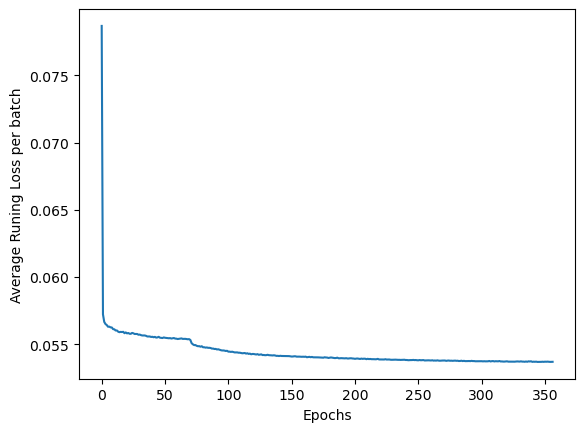

In [74]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [75]:
torch.save(final_model, 'model_100206_6g_02.pt')